In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Deep Neural Network
## GAN 

### 2 x 2 images

<img src='../../prasami_images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align = "left"/>

## Import Statements

In [1]:
###-----------------
### Import Libraries
###-----------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# some global variables

RANDOM_STATE = 24
np.random.RandomState(seed=RANDOM_STATE)

# input and output directories
inpDir = '../input'
outDir = '../output'

# Set the ploting parameters
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 4),
          'axes.labelsize': 'medium',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium',
          #'text.usetex':True,
          #'text.latex.unicode':True
         }

plt.rcParams.update(params)

# Hyperparameters
ALPHA = 0.01 # learning rate

EPOCHS = 1000

## Plot images

In [3]:
def fn_plot_samples(samples, m, n):
    
    fig, axes = plt.subplots(figsize=(n*2, m*2), # as per the elements
                             nrows=m, ncols=n,  # columns and rows
                             sharey=True, sharex=True) # same axis for all images
    
    axes = axes.flatten()

    for ax, img in zip(axes, samples):
        
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        
        im = ax.imshow( 1 - img.reshape((2,2)), cmap='Greys_r')  # show images 
        
    return fig, axes

## Sigmoid Function

In [4]:
def fn_sigmoid(z):
    
    return 1/(1.0 + np.exp(-z))

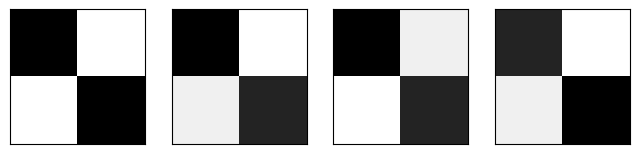

In [5]:
# Examples of faces

faces = [np.array ( [ 1.0, 0.0, 0.0, 1.0 ] ),
         np.array ( [ 0.9, 0.1, 0.2, 0.8 ] ),
         np.array ( [ 0.9, 0.2, 0.1, 0.8 ] ),
         np.array ( [ 0.8, 0.1, 0.2, 0.9 ] ),
         np.array ( [ 0.8, 0.2, 0.1, 0.9 ] )]
    
_ = fn_plot_samples(faces, 1, 4)

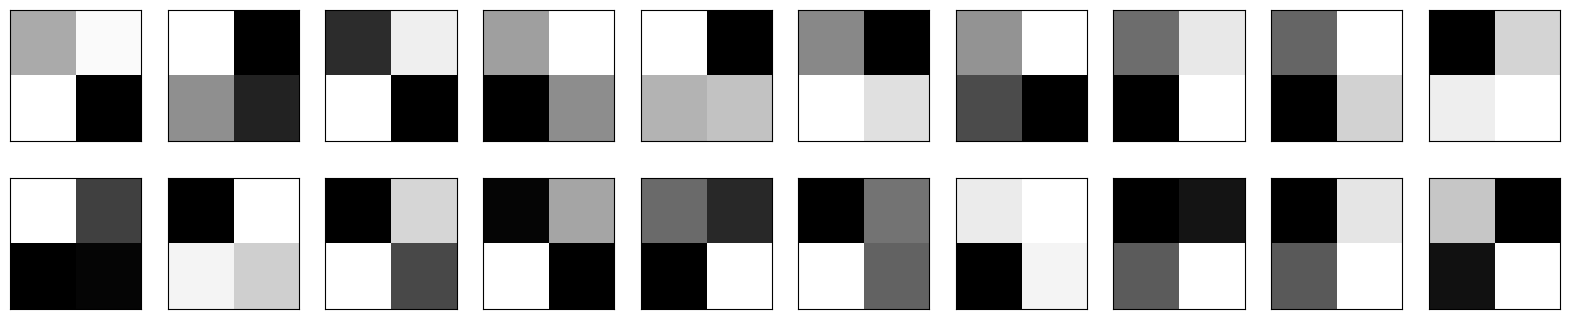

In [6]:
noise = [np.random.random((2,2)).round(2) for i in range(20)]

_ = fn_plot_samples(noise, 2,10)

In [7]:
nn_input_dim = 4

# Discriminator class
class Discriminator():
    
    def __init__(self):

        self.weights = np.random.rand(nn_input_dim) / np.sqrt(nn_input_dim)
        
        self.bias = 0.0 # bias can be zero
        
    
    # Forward Pass
    def forward(self, x):
        return fn_sigmoid(np.dot(x, self.weights) + self.bias)
    
    
    # Forward calculation error
    def image_error(self, image):
        prediction = self.forward(image)
        # We want the prediction to be 1, so the error is -log(prediction)
        return -np.log(prediction)
    
    
    def derivatives_from_image(self, image):
        y_pred = self.forward(image)     
        dW = image * (y_pred -1) # (a - y) 
        db = y_pred-1
        return dW, db
    
    
    # Gradient updates
    def update_from_image(self, x):
        dW, db = self.derivatives_from_image(x)        
        self.weights -= ALPHA * dW
        self.bias -= ALPHA * db
        
        
    #Error from the noise    
    def noise_error(self, noise):
        y_pred = self.forward(noise)
        # We want the prediction to be 0, so the error is -log(1-prediction)
        return -np.log(1-y_pred)
    
    
    # Derivatives from the noise
    def derivatives_from_noise(self, noise):
        y_pred = self.forward(noise)
        dW = noise * y_pred
        db = y_pred
        return dW, db
    
    
    # Gradient update
    def update_from_noise(self, noise):
        dW, db = self.derivatives_from_noise(noise)
        self.weights -= ALPHA * dW
        self.bias -= ALPHA * db

In [8]:
# Generator class
class Generator():
    
    def __init__(self):
        self.weights = np.random.rand(nn_input_dim) / np.sqrt(nn_input_dim)
        self.biases = np.zeros(nn_input_dim) # as earlier bias can be zero

    # Forward pass
    def forward(self, z):
        return fn_sigmoid(z * self.weights + self.biases) # activations from generated image

    
    # Error Calculations
    def error(self, z, discriminator):
        x = self.forward(z)        
        # Pass through the discriminator to get y
        y = discriminator.forward(x)
        # Generator wants discriminator to predict it as image (y = 1)
        return -np.log(y)

    
    # Calculate the derivatives
    def derivatives(self, z, discriminator):
        
        # Get Discriminator weights and biases
        discriminator_weights = discriminator.weights
        
        discriminator_bias = discriminator.bias
        
        # forward pass of z
        x = self.forward(z) # activations from Generator 
        y = discriminator.forward(x) # activations from Generator submitted to Discriminator
        factor = - ( 1 - y ) * discriminator_weights * x *( 1 - x ) # -[ 1 - D(G(z))].W.Gi.(1-Gi)
        dW = factor * z # multiply factor by z       
        db = factor
        return dW, db
    
    # Update generator weights
    def update(self, z, discriminator):
        dW, db = self.derivatives(z, discriminator)
        self.weights -= ALPHA * dW
        self.biases -= ALPHA * dW

In [9]:
D = Discriminator()
G = Generator()

errors_discriminator = []
errors_generator = []

for epoch in range(EPOCHS):    
    for face in faces:
        D.update_from_image(face)
        z = np.random.rand()
        errors_discriminator.append(sum(D.image_error(face) + D.noise_error(z)))
        errors_generator.append(G.error(z, D))
        noise = G.forward(z)
        D.update_from_noise(noise)
        G.update(z, D)

In [10]:
generated_images = []
for i in range(100):
    
    z = np.random.random() # generate a random number
    
    generated_image = G.forward(z) # call forward method of Generator class
    
    generated_images.append(generated_image)

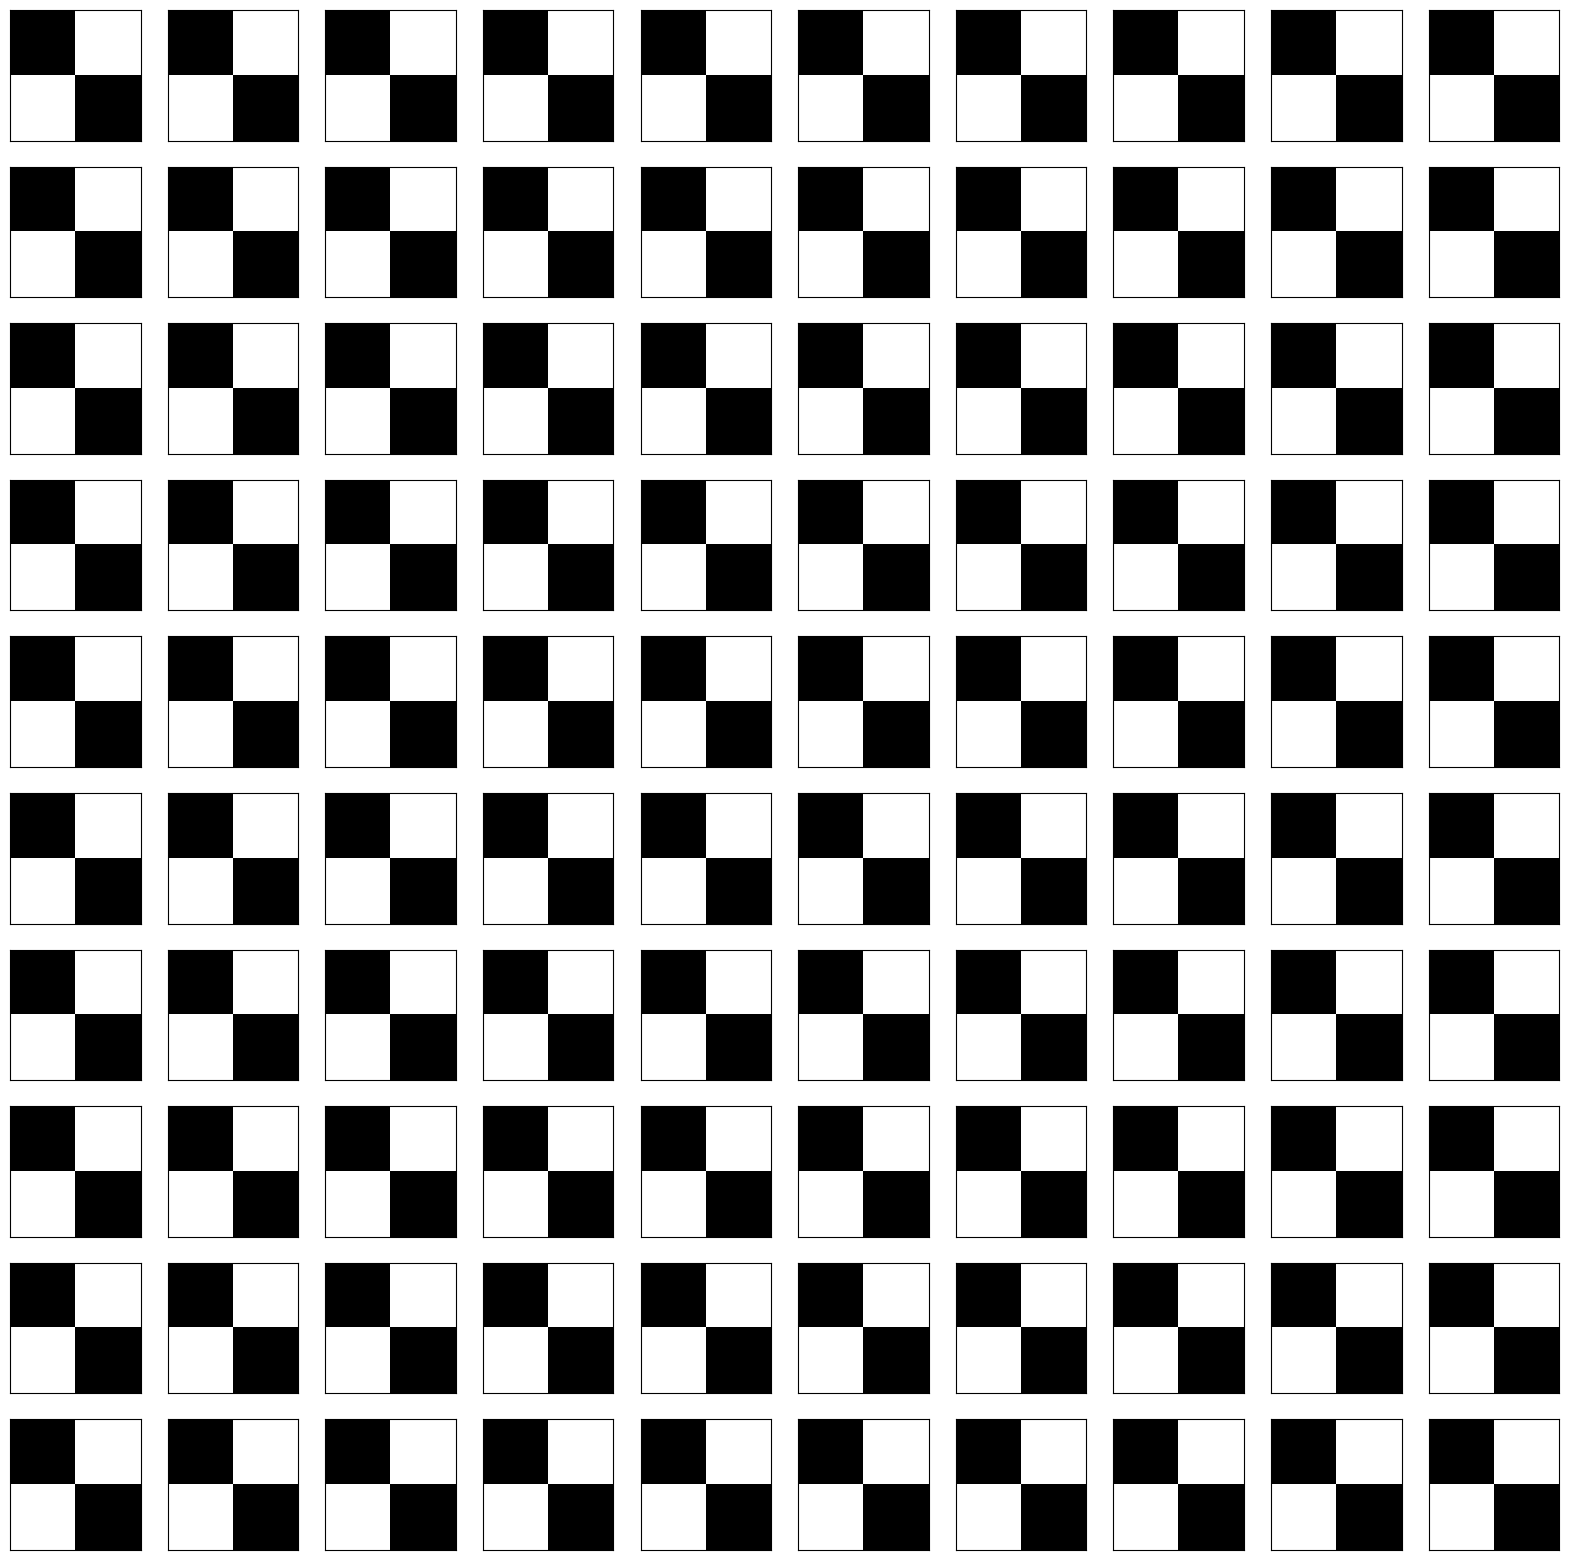

In [11]:
_ = fn_plot_samples(generated_images, 10, 10)